### Imports

In [1]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
import os
import random
import joblib
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

### Function defines

In [2]:
def applyConvolution(src : cv2.Mat, kernel, dtype):
    h, w  = src.shape[:2]

    kH, kW = kernel.shape[:2]
    padH, padW = kH // 2, kW // 2

    dst = src.copy()

    for i in range(padH, h - padH):
        for j in range(padW, w - padW):
            value = 0.0
            for u in range(kH):
                for v in range(kW):
                    value += kernel[int(u)][int(v)] * src[int(i + u - kH)][int(j + v - kW)]
            dst[i][j] = value

    return dst

In [3]:
def HOG(image, blockSize, cellSize, nbins):
    h, w  = image.shape[:2]

    image = np.float32(image)
    gx = applyConvolution(image, np.float32([[-1, 0, 1]]), np.float32)
    gy = applyConvolution(image, np.float32([[-1], [0], [1]]), np.float32)

    magnitude = np.sqrt(gx**2 + gy**2)
    angle = np.arctan2(gy, gx) * (180 / np.pi) % 180

    cW, cH = cellSize

    hist = np.zeros((h // cH, w // cW, nbins), np.float32)

    binLength = 180.0 / float(nbins)

    for i in range(0, h, cH):
        for j in range(0, w, cW):
            for u in range(i, i + cH):
                for v in range(j, j + cW):
                    mH = angle[int(u)][int(v)] / binLength
                    lH = float(math.floor(mH))
                    rH = float(math.floor(mH + 1) % nbins)
                    cL = 1.0 - (mH - lH)
                    cR = 1.0 - abs(rH - mH)
                    hist[int(i / cH)][int(j / cW)][int(lH)] += cL * magnitude[u][v]
                    hist[int(i / cH)][int(j / cW)][int(rH)] += cR * magnitude[u][v]

    bW, bH = blockSize

    normHist = []

    for i in range(0, h - cH, cH):
        for j in range(0, w - cW, cW):
            norm = np.array([], dtype=np.float32)
            for u in range(i, i + bH, cH):
                for v in range(j, j + bW, cW):
                    norm = np.concatenate([norm, hist[int(i / cH)][int(j / cW)]])
            norm = norm / (bH * bW)
            normHist.append(norm)

    normHist = np.float32(normHist)

    return (hist.ravel(), normHist.ravel())

Constants

In [4]:
CELL_SIZE = (8, 8)
BLOCK_SIZE = (16, 16)
NBINS = 9
MAX_T = 300
MAX_TRAIN = 40
MAX_TEST = 14
CLASSES_LIST = ["A", "B"]
EPSILON = 1e-10

In [5]:
class WeakLearner:
  def __init__(self, feature, threshold, class_label, error):
    self.feature = feature
    self.threshold = threshold
    self.class_label = class_label
    self.error = error

  def classify(self, X):
    return self.class_label if X[self.feature] < self.threshold else -self.class_label


In [6]:
class StrongClassifier:
  def __init__(self):
    self.weak_learners = np.array([])
    self.alphas = np.array([])

  def classify(self, X):
    sum = np.sum(self.alphas * [weak.classify(X) for weak in self.weak_learners])
    return 1 if sum >= 0 else -1

  def add_weak_learner(self, weak_learner, alpha):
    self.weak_learners = np.append(self.weak_learners, weak_learner)
    self.alphas = np.append(self.alphas, alpha)

In [7]:
def find_weak_learner(X, y, weight):
  best_weak_learner = None
  best_error = float('inf')

  h, w  = X.shape[:2]

  for j in range(w):
    sorted_values = np.sort(X[:, j])
    thresholds = (sorted_values[:-1] + sorted_values[1:]) / 2
    for threshold in thresholds:
      for class_label in [-1, 1]:
        error = 0
        for i in range(h):
          zi = 0
          if X[i][j] < threshold:
            zi = class_label
          else:
            zi = -class_label
          if zi * y[i] < 0:
            error += weight[i]

        if error < best_error:
          best_error = error
          best_weak_learner = WeakLearner(j, threshold, class_label, error)

  return best_weak_learner

In [8]:
def find_strong_classifier(X, y):
  h, w  = X.shape[:2]
  weight = np.ones(h) / h
  classifier = StrongClassifier()

  for t in range(MAX_T):
    weak_learner = find_weak_learner(X, y, weight)
    alpha = 0.5 * math.log((1 - weak_learner.error + EPSILON) / (weak_learner.error + EPSILON))
    predictions = np.array([weak_learner.classify(X[i]) for i in range(h)])
    weight *= np.exp(-alpha * y * predictions)
    s = np.sum(weight)
    weight /= s
    classifier.add_weak_learner(weak_learner, alpha)

  return classifier


In [9]:
def process_image(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(gray, (3, 3), 0)
  resized = cv2.resize(blur, (128, 128))
  return resized

Process image testing

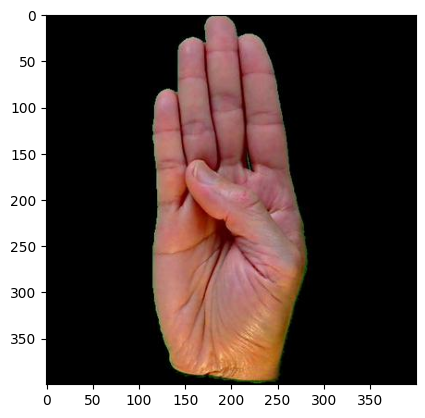

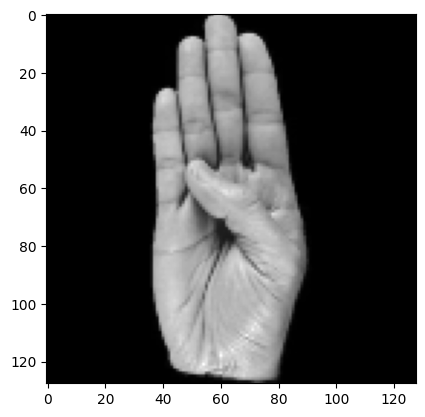

In [10]:
test_image = cv2.imread(os.path.join("dataset", "test", "B", "hand1_b_bot_seg_5_cropped.jpeg"))
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.show()

processed_image = process_image(test_image)
plt.imshow(processed_image, cmap='gray')
plt.show()

In [11]:
def load_data(dir, limit):
  X = []
  y = []

  for cls in CLASSES_LIST:
    category = os.path.join(dir, cls)
    X_category = []
    y_category = []

    for img in os.listdir(category):
      image = cv2.imread(os.path.join(category, img))
      processed_image = process_image(image)
      _, features = HOG(processed_image, BLOCK_SIZE, CELL_SIZE, NBINS)
      X_category.append(features)
      if cls == CLASSES_LIST[0]:
        y_category.append(1)
      else:
        y_category.append(-1)

    data_category = list(zip(X_category, y_category))
    random.shuffle(data_category)
    X_shuffled, y_shuffled = zip(*data_category)
    X += X_shuffled[:limit]
    y += y_shuffled[:limit]

  X = np.array(X)
  y = np.array(y)

  return X, y

In [12]:
def compute_confusion_matrix(y_pred, y_real):
  h = y_pred.shape[0]
  confusion_matrix = np.zeros((2, 2))

  for i in range(h):
    if y_real[i] == 1:
      if y_pred[i] == 1:
        confusion_matrix[0][0] += 1
      else:
        confusion_matrix[0][1] += 1
    else:
      if y_pred[i] == 1:
        confusion_matrix[1][0] += 1
      else:
        confusion_matrix[1][1] += 1

  return confusion_matrix

In [13]:
def test_classifier(classifier, X, y):
  y_pred = np.array([classifier.classify(X[i]) for i in range(X.shape[0])])
  confusion_matrix = compute_confusion_matrix(y_pred, y)

  accuracy = (confusion_matrix[0][0] + confusion_matrix[1][1]) / np.sum(confusion_matrix)
  precision = confusion_matrix[0][0] / (confusion_matrix[0][0] + confusion_matrix[0][1])
  recall = confusion_matrix[0][0] / (confusion_matrix[0][0] + confusion_matrix[1][0])
  f1 = 2 * precision * recall / (precision + recall)

  return confusion_matrix, accuracy, precision, recall, f1

In [14]:
def test_adaboost(classifier, X, y):
  y_pred = classifier.predict(X)
  confusion_matrix = compute_confusion_matrix(y_pred, y)

  accuracy = (confusion_matrix[0][0] + confusion_matrix[1][1]) / np.sum(confusion_matrix)
  precision = confusion_matrix[0][0] / (confusion_matrix[0][0] + confusion_matrix[0][1])
  recall = confusion_matrix[0][0] / (confusion_matrix[0][0] + confusion_matrix[1][0])
  f1 = 2 * precision * recall / (precision + recall)

  return confusion_matrix, accuracy, precision, recall, f1

Data loading for training

In [15]:
X, y = load_data(os.path.join("dataset", "train"), MAX_TRAIN)

KeyboardInterrupt: 

Training the model

In [122]:
classifier = find_strong_classifier(X, y)

Saving the model

In [130]:
joblib.dump(classifier, 'adaboost_model.joblib')

['adaboost_model.joblib']

In [15]:
loaded_classifier = joblib.load("adaboost_model.joblib")

Testing the model by predicting two images from different classes

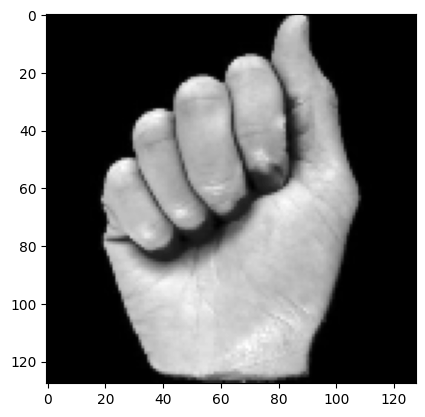

1


In [27]:
test_imageA = cv2.imread(os.path.join("dataset", "test", "A", "hand1_a_bot_seg_5_cropped.jpeg"))
processed_imageA = process_image(test_imageA)

plt.imshow(processed_imageA, cmap='gray')
plt.show()

_, featuresA = HOG(processed_imageA, BLOCK_SIZE, CELL_SIZE, NBINS)
print(loaded_classifier.classify(featuresA))

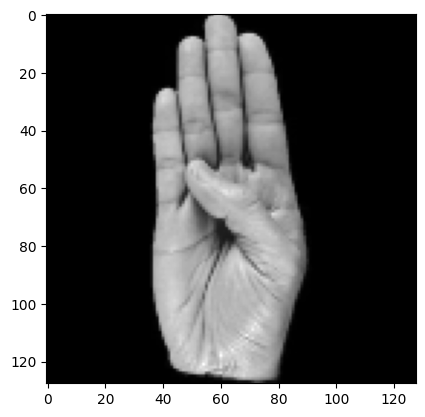

-1


In [28]:
test_imageB = cv2.imread(os.path.join("dataset", "test", "B", "hand1_b_bot_seg_5_cropped.jpeg"))
processed_imageB = process_image(test_imageB)

plt.imshow(processed_imageB, cmap='gray')
plt.show()

_, featuresB = HOG(processed_imageB, BLOCK_SIZE, CELL_SIZE, NBINS)
print(loaded_classifier.classify(featuresB))

In [18]:
Xtest, ytest = load_data(os.path.join("dataset", "test"), MAX_TEST)

Testing the model by make it predict all the images from the test set

In [ ]:
confusion_matrix, accuracy, precision, recall, f1 = test_classifier(loaded_classifier, Xtest, ytest)

sns.heatmap(confusion_matrix, annot=True, fmt='g', xticklabels=['A', 'B'], yticklabels=['A', 'B'])

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

#### Training the sklearn AdaBoost model and testing it

In [ ]:
base_estimator = DecisionTreeClassifier(max_depth=1)
adaboost = AdaBoostClassifier(estimator=base_estimator, n_estimators=MAX_T, random_state=42)
adaboost.fit(X, y)

In [160]:
joblib.dump(adaboost, 'adaboost_sklearn_model.joblib')

['adaboost_sklearn_model.joblib']

In [21]:
loaded_sklearn_classifier = joblib.load("adaboost_sklearn_model.joblib")

In [22]:
test_imageA = cv2.imread(os.path.join("dataset", "test", "A", "hand1_a_bot_seg_5_cropped.jpeg"))
processed_imageA = process_image(test_imageA)
_, featuresA = HOG(processed_imageA, BLOCK_SIZE, CELL_SIZE, NBINS)
featuresA_reshaped = featuresA.reshape(1, -1)
print(loaded_sklearn_classifier.predict(featuresA_reshaped))

[1]


In [23]:
test_imageB = cv2.imread(os.path.join("dataset", "test", "B", "hand1_b_bot_seg_5_cropped.jpeg"))
processed_imageB = process_image(test_imageB)
_, featuresB = HOG(processed_imageB, BLOCK_SIZE, CELL_SIZE, NBINS)
featuresB_reshaped = featuresB.reshape(1, -1)
print(loaded_sklearn_classifier.predict(featuresB_reshaped))

[-1]


In [ ]:
confusion_matrix, accuracy, precision, recall, f1 = test_adaboost(loaded_sklearn_classifier, Xtest, ytest)

sns.heatmap(confusion_matrix, annot=True, fmt='g', xticklabels=['A', 'B'], yticklabels=['A', 'B'])

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")